In [1]:
import numpy as np
import pandas as pd
from scipy import signal
import statsmodels.tsa.stattools
import matplotlib.pyplot as plt
%matplotlib inline 
plt.style.use('seaborn-darkgrid')

In [2]:
# load UFO data
ufo_data = pd.read_csv('scrubbed.csv', usecols=[0, 4, 5], low_memory=False)
ufo_data['datetime'] = pd.to_datetime(ufo_data['datetime'], errors='coerce')

In [3]:
# load sunspot data
sunspots = pd.read_csv('data_sunspots.csv', usecols=[0, 1, 2, 5])# http://sidc.oma.be/silso/newdataset 
sunspots['datetime'] = pd.to_datetime((sunspots.YEAR*10000+sunspots.MONTH*100+sunspots.DAY).apply(str),format='%Y%m%d')

In [4]:
sunspots['dateidx'] = pd.to_datetime((sunspots.YEAR*10000+sunspots.MONTH*100+sunspots.DAY).apply(str),format='%Y%m%d')

In [5]:
# Format and group UFO rows by month
df1 = ufo_data
df1 = df1[(df1['datetime'] > '1997-03-30') & (df1['datetime'] <= '2012-12-31')]
df1m = df1.set_index('datetime').groupby(pd.TimeGrouper('1M')).agg(['count'])

In [6]:
# Format and group sunspot data by month
df2 = sunspots  
df2 = df2[(df2['datetime'] > '1997-03-30') & (df2['datetime'] <= '2012-12-31')]
df2m = df2.set_index('datetime').groupby(pd.TimeGrouper('1M')).mean()

In [7]:
# # Add month index to join on
df1m['YEAR'] = df2m['YEAR']
df1m['MONTH'] = df2m['MONTH']

In [8]:
# Merge UFO and sunspot data
merged = pd.merge(df1m,df2m, on=['YEAR','MONTH'], left_index=True)

In [9]:
Y1 = merged['shape', 'count']
Y2 = merged.Nb

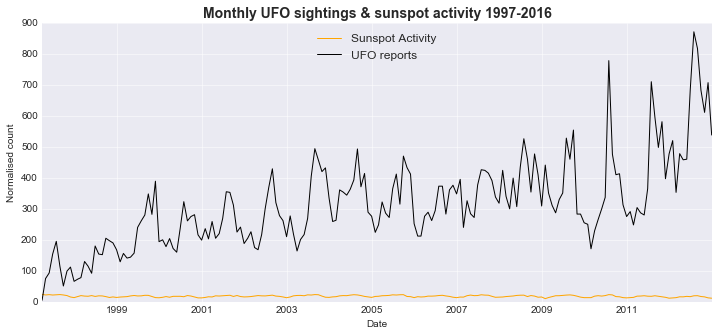

In [10]:
# Draw plot
plt.figure(figsize=(12,5))
plt.plot(Y2,color='orange',alpha=1, label='Sunspot Activity')
plt.plot(Y1,color='k', label='UFO reports')
plt.title('Monthly UFO sightings & sunspot activity 1997-2016', fontsize=14, fontweight='bold')
plt.ylabel('Normalised count')
plt.xlabel('Date')
plt.legend(loc='upper center')
plt.show()

In [11]:
# Normalise to min/max
Y1n = (Y1-min(Y1))/(max(Y1)-min(Y1))
Y2n = (Y2-min(Y2))/(max(Y2)-min(Y2))

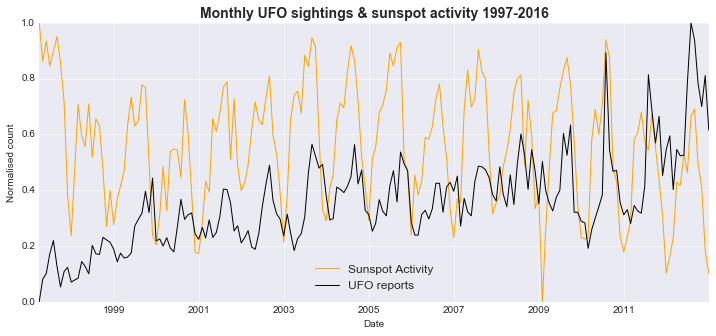

In [12]:
# Draw plot
plt.figure(figsize=(12,5))
plt.plot(Y2n,color='orange',alpha=1, label='Sunspot Activity')
plt.plot(Y1n,color='k', label='UFO reports')
plt.title('Monthly UFO sightings & sunspot activity 1997-2016', fontsize=14, fontweight='bold')
plt.ylabel('Normalised count')
plt.xlabel('Date')
plt.legend(loc='lower center')
plt.show()

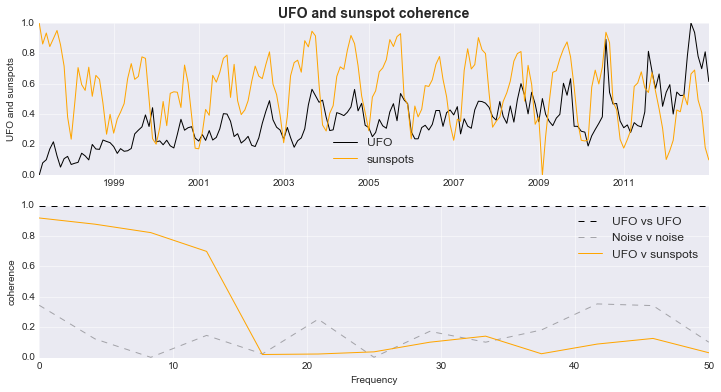

In [13]:
# UFO - test signal coherence with sunspot counts
nfft = 24
dt = 0.01
n = 1./dt
plt.figure(figsize=(12,6))
plt.subplot(211)
plt.title('UFO and sunspot coherence', fontsize=14, fontweight='bold')
plt.plot(Y1n,'k',label="UFO")
plt.plot(Y2n,color='orange',label="sunspots")
plt.ylabel('UFO and sunspots')
plt.legend(loc='lower center')
plt.subplot(212)
cxy, f = plt.cohere(Y1n, Y1n, nfft,n , color='k', alpha=1, linestyle='--', label='UFO vs UFO')
cxy, f = plt.cohere(np.random.randn(len(Y1)), np.random.randn(len(Y1)), nfft,n , color='k', alpha=.3, linestyle='--', label='Noise v noise')
cxy, f = plt.cohere(Y1n, Y2n, nfft, n, color='orange', alpha=1, label='UFO v sunspots')
plt.ylabel('coherence')
plt.legend(loc='upper right')
plt.ylim(0,1)
plt.show()

In [14]:
# Granger test for Y2 x Y3
sig_noise = Y1 + np.random.randn(len(Y1))
x1 = pd.DataFrame([Y1,Y2])
x1 = x1.transpose()
x2 = pd.DataFrame([Y1,sig_noise])
x2 = x2.transpose()
x3 = pd.DataFrame([np.random.randn(len(Y1)),np.random.randn(len(Y1))])
x3 = x3.transpose()
maxlag = 24
gr1 = statsmodels.tsa.stattools.grangercausalitytests(x1, maxlag, verbose=False)
gr2 = statsmodels.tsa.stattools.grangercausalitytests(x2, maxlag, verbose=False)
gr3 = statsmodels.tsa.stattools.grangercausalitytests(x3, maxlag, verbose=False)

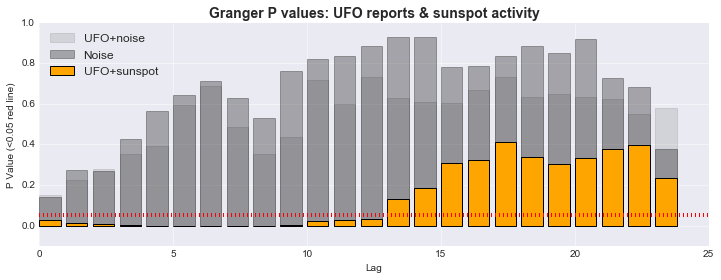

In [15]:
#Plot the granger p values 
resd1 = {}
for i in range(0,maxlag):
    resd1[i] = gr1[i+1][0]['params_ftest'][1]  
resd2 = {}
for i in range(0,maxlag):
    resd2[i] = gr2[i+1][0]['params_ftest'][1]  
resd3 = {}
for i in range(0,maxlag):
    resd3[i] = gr3[i+1][0]['params_ftest'][1]   
pvals1 = pd.Series(resd1)
pvals2 = pd.Series(resd2)
pvals3 = pd.Series(resd3)
plt.figure(figsize=(12,4))
plt.ylim(-0.1,1)
plt.bar(pvals2.index,pvals2,color='k',alpha=.1, label='UFO+noise')
plt.bar(pvals3.index,pvals3,color='k',alpha=.3, label="Noise")
plt.bar(pvals1.index,pvals1, color='orange', label='UFO+sunspot')
plt.axhline(0.05, ls=':', c='r', linewidth=4)
plt.legend(loc='upper left')
plt.title('Granger P values: UFO reports & sunspot activity', fontsize=14, fontweight='bold')
plt.xlabel('Lag')
plt.ylabel('P Value (<0.05 red line)')
plt.savefig('./imgs/UFOsunspots_granger_pvals.png')